Introductory information: Application - a mobile utility. The monetization model is subscription, there is a trial period of 7 days with a further transition to payment of 4.99 USD per week

It is necessary to calculate the user's current LTV using cohort analysis, predict what LTV will be for six months

In [1]:
import pandas as pd
import re
import numpy as np
import datetime as datetime

In [3]:
df['revenue'] = [0 if df['is_trial_period'][x] == True else 4.99 for x in range(len(df))]

Let's calculate the income for each cohort. Cohorts are formed based on the start date of using the utility

In [205]:
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

%matplotlib inline

df = pd.read_excel('C:/Users/Lenovo/Desktop/test case data analyst.xlsx')
df['revenue'] = [0 if df['is_trial_period'][x] == True else 4.99 for x in range(len(df))]

df['OrderPeriod'] = df.purchase_date.apply(lambda x: x.strftime('%Y %U'))
df.head()

df.set_index('user_id', inplace=True)

df['CohortGroup'] = df.groupby(level=0)['purchase_date'].min().apply(lambda x: x.strftime('%Y %U'))

df.reset_index(inplace=True)
df.head()

grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'revenue': np.sum})

cohorts.rename(columns={'user_id': 'TotalUsers'}, inplace=True)

def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [206]:
ltv_matrix = cohorts.reset_index()[['CohortGroup','CohortPeriod','revenue']].pivot(index='CohortGroup',columns='CohortPeriod')

In [207]:
ltv_matrix

revenue                                                           \
CohortPeriod       1         2         3         4        5        6        7   
CohortGroup                                                                     
2020 00        24.95   9381.20   7729.51   6771.43  6222.53  5628.72  5094.79   
2020 01        14.97  15493.95  12799.35  11247.46  9975.01  9011.94  4950.08   
2020 02         0.00  15663.61  12729.49  11002.95  9735.49  5114.75      NaN   
2020 03         0.00  13512.92  10503.95   8842.28  4795.39      NaN      NaN   
2020 04         9.98  12764.42  10024.91   5099.78      NaN      NaN      NaN   
2020 05         4.99  14266.41   6601.77       NaN      NaN      NaN      NaN   
2020 06         0.00   8857.25       NaN       NaN      NaN      NaN      NaN   
2020 07         0.00       NaN       NaN       NaN      NaN      NaN      NaN   

                       
CohortPeriod        8  
CohortGroup            
2020 00       1571.85  
2020 01           NaN  
2020 02           NaN  
2020 03           NaN  
2020 04           NaN  
2020 05           NaN  
2020 06           NaN  
2020 07           NaN

Построим heatmap на основе дохода по когортам

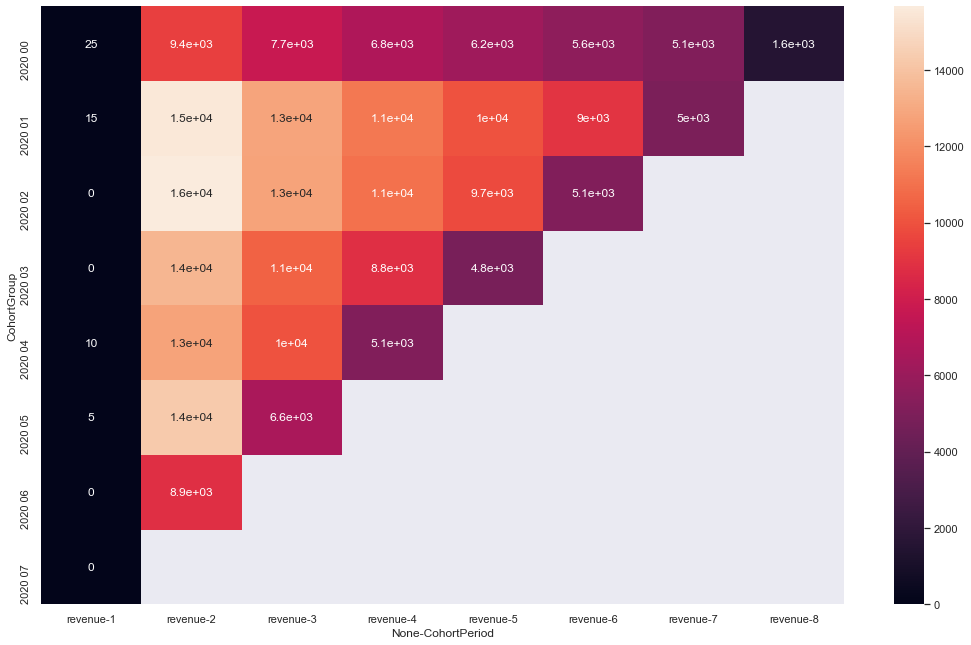

In [237]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
sns.set(rc={'figure.figsize':(18,11)})

ax = sns.heatmap(ltv_matrix, annot=True)

Forecasting LTV

In [373]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [375]:
data['revenue'] = [0 if data['is_trial_period'][x] == True else 4.99 for x in range(len(data))]

In [376]:
data = data.query('is_trial_period == False').merge(
data.query('is_trial_period == True')[['purchase_date','user_id']].rename(columns = {'purchase_date':'trial_date'})\
                             .sort_values(['user_id','trial_date'], ascending = [True,True]).groupby(['user_id'],as_index = False).head(1),
    how = 'left', on = 'user_id'
)

In [377]:
data['day'] = pd.to_timedelta(data['purchase_date'] - data['trial_date'].min()).dt.days + 1
data['day'] = data['day'].astype(int)

In [378]:
data['purchase_date'] = data.purchase_date.apply(lambda x: x.strftime('%Y %U'))

In [379]:
data['trial_date'] = data.trial_date.apply(lambda x: x.strftime('%Y %U'))

In [380]:
rev = data.groupby(['user_id'],as_index = False).agg({'revenue':'sum'})

In [381]:
data = data.sort_values(['user_id','purchase_date','trial_date'], ascending = [True,True,True])\
.groupby(['user_id']).head(1).reset_index(drop = True)
data['revenue'] = rev['revenue']

In [382]:
data = data.sort_values('purchase_date')
def get_cum_sum(date):
    return data['revenue'].where(data['purchase_date']<=date).sum()

data['cum_sum'] = data['purchase_date'].map(lambda x: get_cum_sum(x))
def get_users_utd(date):
    return data['user_id'].where(data['purchase_date'] <=date).count()

data['users_n_utd'] = data['purchase_date'].map(lambda x: get_users_utd(x))
data['ltv'] = data['cum_sum']/data['users_n_utd'].astype(float)

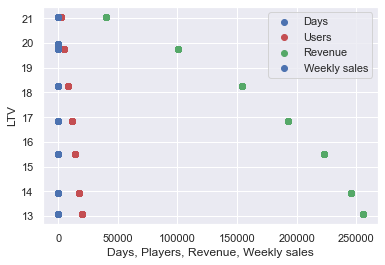

In [384]:
plt.scatter(data['day'], data['ltv'], label ='Days')
plt.scatter(data['users_n_utd'], data['ltv'], color='r', label='Users')
plt.scatter(data['cum_sum'], data['ltv'], color='g', label='Revenue')
plt.scatter(data['revenue'], data['ltv'], color='b', label='Weekly sales')
plt.xlabel('Days, Players, Revenue, Weekly sales')
plt.ylabel('LTV')
plt.legend()

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



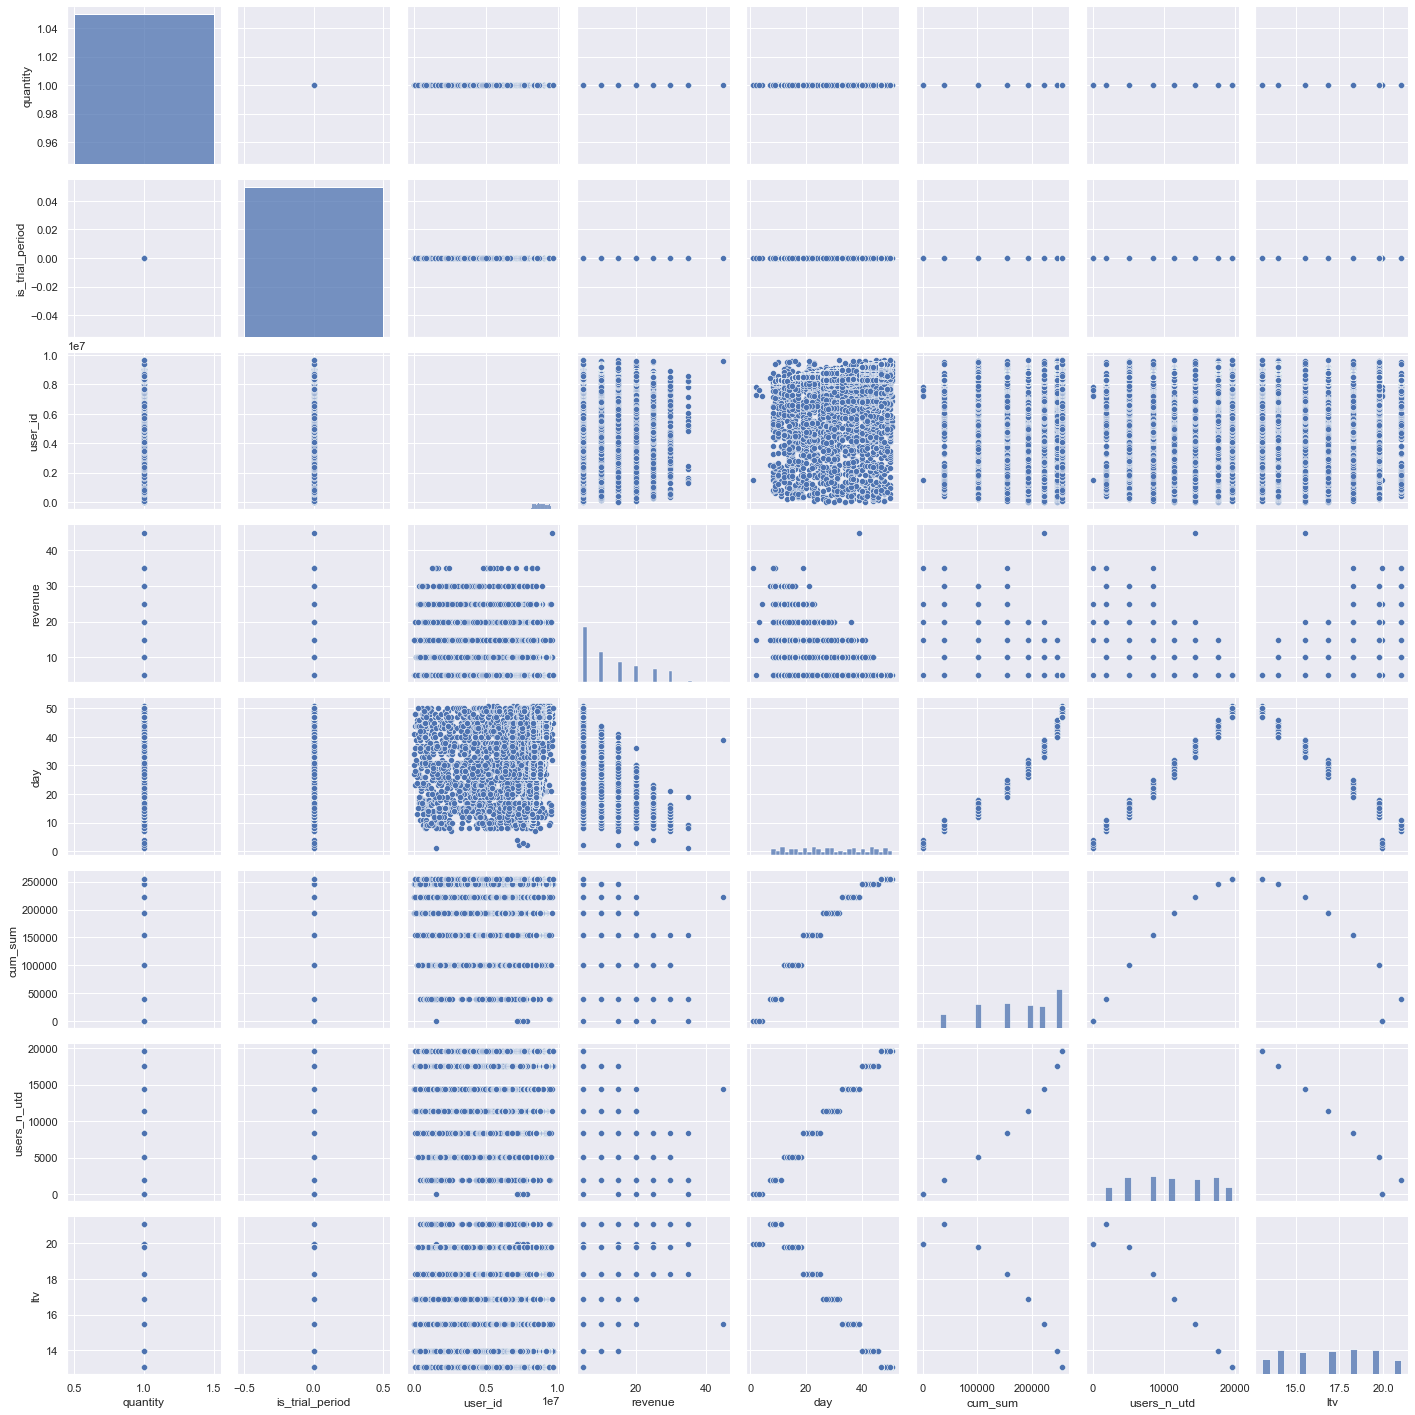

In [385]:
sns.pairplot(data)

In [386]:
ltv_data = data[['day','users_n_utd', 'cum_sum', 'ltv']]
X = ltv_data[['day', 'users_n_utd','cum_sum']]
y = ltv_data['ltv']

Text(0, 0.5, 'LTV')

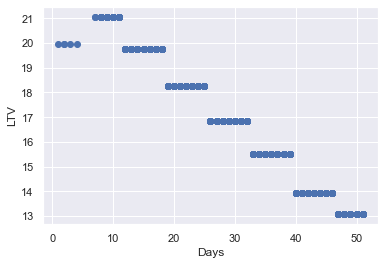

In [387]:
plt.scatter(data['day'], data['ltv'])
plt.xlabel('Days')
plt.ylabel('LTV')

In [388]:
X_l = X['day'].values 
Y_l = y.values

coefs_l, cov = optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  X_l,  Y_l)

print (coefs_l)

def ltv_func(param):
    result = coefs_l[0] + coefs_l[1]*np.log(param)
    return result
    

ltv_30_51 = ltv_func([30., 51.])
ltv30 = round(ltv_30_51[0],2)
ltv51 = round(ltv_30_51[1],2)

print ("LTV by day 30: " + str(ltv30))
print ("LTV by day 51: " + str(ltv51))

[32.63714098 -4.83418918]
LTV by day 30: 16.2
LTV by day 51: 13.63


we got that within six months LTV will fall

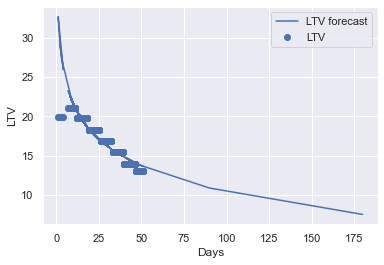

In [389]:
days = np.hstack([X_l, [90, 180]])
plt.scatter(X_l,y.values)
plt.plot(days,ltv_func(days.reshape(-1, 1)))
plt.xlabel('Days')
plt.ylabel('LTV')
plt.legend(['LTV forecast', 'LTV'])

ROMI

In [407]:
data['romi'] = (data['ltv'] - data['cost']) / data['cost'] * 100

In [408]:
data

,product_id,quantity,is_trial_period,purchase_date,user_id,revenue,trial_date,day,cum_sum,users_n_utd,ltv,cost,romi
1458,1week_4.99_USD_subscription_7days_trial,1,False,2020 00,7293651,14.97,2020 03,2,99.80,5,19.960000,6,232.666667
1428,1week_4.99_USD_subscription_7days_trial,1,False,2020 00,7204327,24.95,2020 02,4,99.80,5,19.960000,6,232.666667
231,1week_4.99_USD_subscription_7days_trial,1,False,2020 00,1511831,34.93,2020 04,1,99.80,5,19.960000,6,232.666667
1743,1week_4.99_USD_subscription_7days_trial,1,False,2020 00,7843318,4.99,2020 07,2,99.80,5,19.960000,6,232.666667
1598,1week_4.99_USD_subscription_7days_trial,1,False,2020 00,7591159,19.96,2020 05,3,99.80,5,19.960000,6,232.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18241,1week_4.99_USD_subscription_7days_trial,1,False,2020 07,9403320,4.99,2020 06,47,255448.08,19546,13.069072,6,117.817866
18240,1week_4.99_USD_subscription_7days_trial,1,False,2020 07,9403211,4.99,2020 06,47,255448.08,19546,13.069072,6,117.817866
18239,1week_4.99_USD_subscription_7days_trial,1,False,2020 07,9403207,4.99,2020 06,47,255448.08,19546,13.069072,6,117.817866
18267,1week_4.99_USD_subscription_7days_trial,1,False,2020 07,9404860,4.99,2020 06,47,255448.08,19546,13.069072,6,117.817866
